In [1]:
### Encoding model for iEEG
# Pedro Pinheiro-Chagas
# Adapted from Christopher Holdgraf's git repo: 
#(https://github.com/choldgraf/paper-encoding_decoding_electrophysiology)

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from modelingtools import delay_time_series, plot_activity_on_brain
from sklearn.linear_model import Ridge, Lasso, LinearRegression,LogisticRegression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import os
import seaborn as sns
import matplotlib.collections as clt
import ptitprince as pt

import sys
np.set_printoptions(threshold=sys.maxsize)


### 1. The data
Task: MMR - calculation, memory verification and "rest" ('17+5=23', 'I ate fruit today'). <br />
Type of data: epoched and baseline corrected, all concatenated. <br />
Brain feature: Normalized HFB power.  <br />

Stimuli features:
0. Task, trial, time, block
1. Task
    - condition(calculation, memory, rest) 
    - type (active, passive)
2. Calculation specs
    - number_format (digit, word, dot)
    - operand_1
    - operand_2
    - operand_min
    - operand_max
    - operation (addition, subtraction, multiplication)
    - ls_sl
    - result 
    - cross_decade
    - presented_result
    - abs_deviant
    - number of digits
3. Memory specs
    - memory type (autobio, self-external, self-internal, fact)
4. Behavior
    - RT
    - Accuracy
    - RT_lock
    
The features were already selected and the encoding matrix was consctructed in Matlab and saved as csv.

#### Plot examplar encoding matrix:

(-0.5, 7816.5, 2741.5, -0.5)

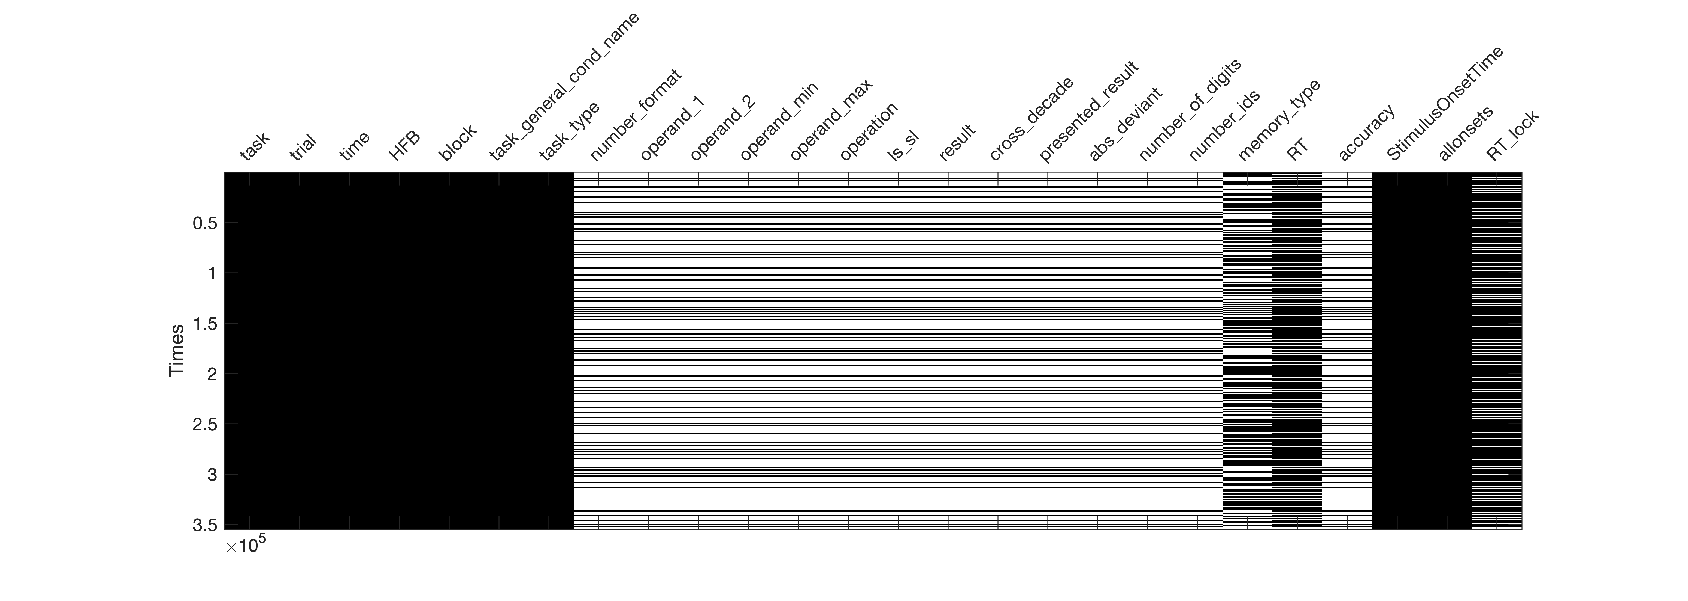

In [2]:
im = plt.imread('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/figures/encoding_matrix.png') 
fig, ax = plt.subplots(figsize=(30, 15))
ax.imshow(im)
plt.axis('off')

### Load the data



In [3]:
data = pd.read_csv('/Users/pinheirochagas/Pedro/Stanford/code/lbcn_encoding_decoding/data/data_61.csv') 
data.head()

,task,trial,time,elect,HFB,block,task_general_cond_name,task_type,number_format,operand_1,...,cross_decade,presented_result,abs_deviant,number_of_digits,memory_type,RT,accuracy,StimulusOnsetTime,allonsets,RT_lock
0,7,1,0.000,61,-0.437685,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
1,7,1,0.002,61,-0.514633,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
2,7,1,0.004,61,-0.598166,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
3,7,1,0.006,61,-0.672080,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653
4,7,1,0.008,61,-0.721583,1,6,1,0,0,...,0,0,0,0,2,3.853186,0,93429.098498,19.603467,23.456653


In [4]:
# Set extreme values to zero (double check spike exclusion)
data.loc[data.loc[:,'HFB']>30, 'HFB'] = 0
# Recode task name
data.loc[data.loc[:,'task_general_cond_name']==4, 'task_general_cond_name'] = 2
data.loc[data.loc[:,'task_general_cond_name']==6, 'task_general_cond_name'] = 1

### Plot all blocks concatenated

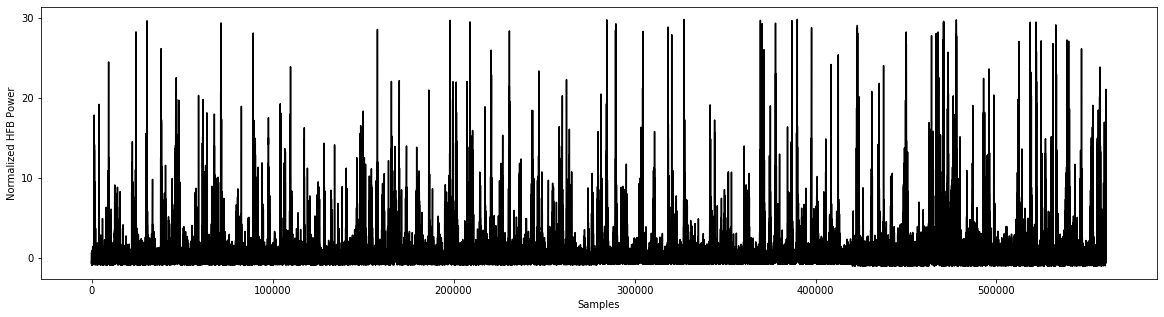

In [5]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(data.loc[:,'HFB'], color='k')
plt.xlabel('Samples')
plt.ylabel('Normalized HFB Power')
plt.rcParams.update({'font.size': 20})

### Plot blocks saparated

/Users/pinheirochagas/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


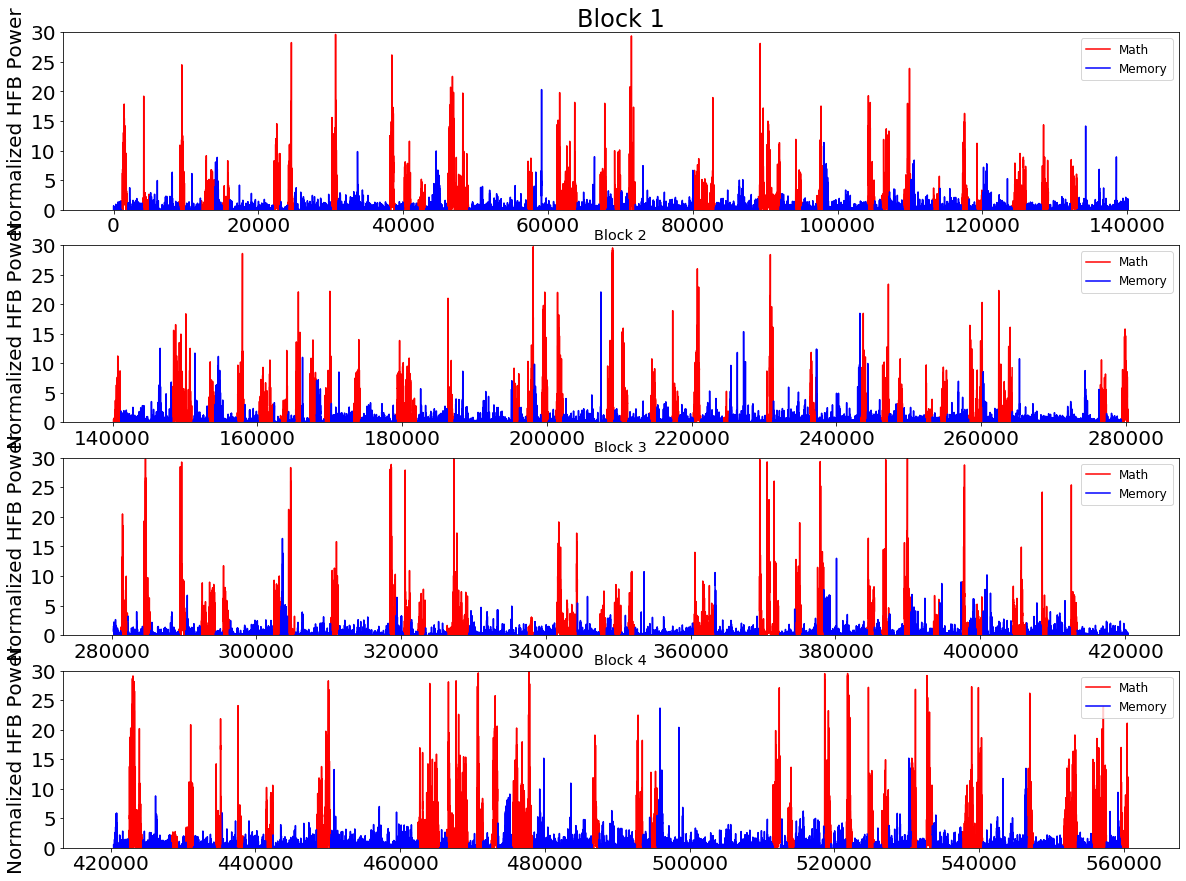

In [6]:
n_blocks = np.int(np.max(data.loc[:,'block']))
fig, ax = plt.subplots(n_blocks,1,figsize=(20, 15))

# Filter trials
math_trials = data.loc[:,'HFB'].copy()
math_trials[data.loc[:,'task_general_cond_name']!=2] = np.nan
memo_trials = data.loc[:,'HFB'].copy()
memo_trials[data.loc[:,'task_general_cond_name']!=1] = np.nan

for i in range(n_blocks):
    #ax[i].plot(samples[data[:,4]==i+1], data[data[:,4]==i+1,3])
    ax[i].plot(math_trials[data.loc[:,'block']==i+1], 'r', label="Math")
    ax[i].plot(memo_trials[data.loc[:,'block']==i+1], 'b', label="Memory")
    ax[i].set_ylim([0,30])
    ax[i].set_title('Block ' + str(i+1))
    plt.rcParams.update({'font.size': 12}) 
    ax[i].set_ylabel('Normalized HFB Power')
    ax[i].legend()


([<matplotlib.axis.YTick at 0x1c41b4cfd0>,
 <a list of 2 Text yticklabel objects>)

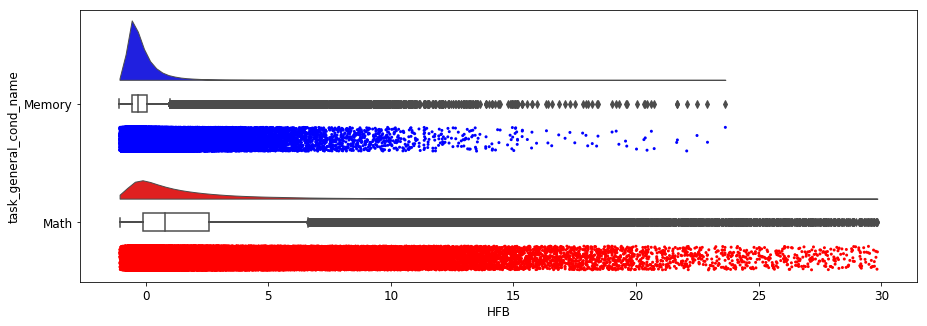

In [161]:
# Overall activity 
my_pal = {1: 'blue', 2: 'red'}
f, ax = plt.subplots(figsize=(15, 5))
ax=pt.RainCloud(x = 'task_general_cond_name', y = 'HFB', data = data, palette = my_pal, bw = 0.1,
                 width_viol = 1, ax = ax, orient = 'h', move = .3)
plt.rcParams.update({'font.size': 14}) 
plt.yticks(np.arange(2), ('Memory', 'Math'))

### Selec the main feature: task:

In [253]:
features = np.array(data.loc[:,'task_general_cond_name'])
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

#### Select feature and add delayed versions

In [255]:
# Define features
features = np.array(data.loc[:,'task_general_cond_name'])
times = np.shape(np.unique(data.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data)
trials = int(r/times)

# Reshape features
features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)

# Add delayed features
fs = 500
time_window = 0.02;

start = 0; stop = 1.5; step = time_window
delays = np.arange(start, stop+step, step)
n_delays = int(len(delays))

X_delayed = np.zeros((trials,1,n_delays,times))
for i in range(x):
    for ii in range(n_delays):
        window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
        X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))

Text(0.5, 1.0, 'Time-Delayed Task Condition')

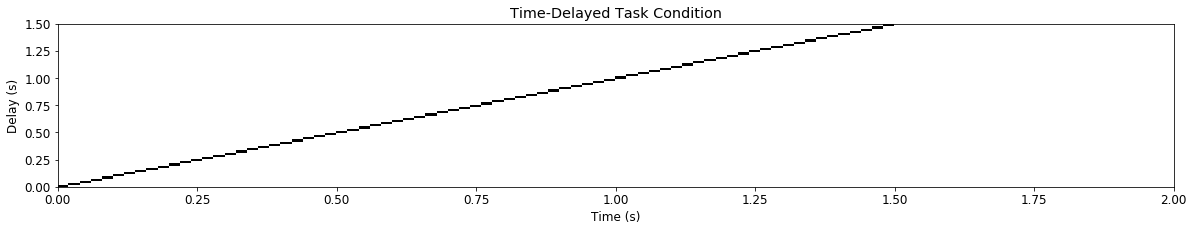

In [258]:
# Plot
times = np.unique(data.loc[:,'time'])
fig, ax = plt.subplots(figsize=(20, 3))
ax.pcolormesh(times, delays,
              X_delayed[1,0,:,:], cmap='binary')
ax.axis('tight')
ax.set_ylabel('Delay (s)')
ax.set_xlabel('Time (s)')
ax.set_title('Time-Delayed Task Condition')

In [259]:
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

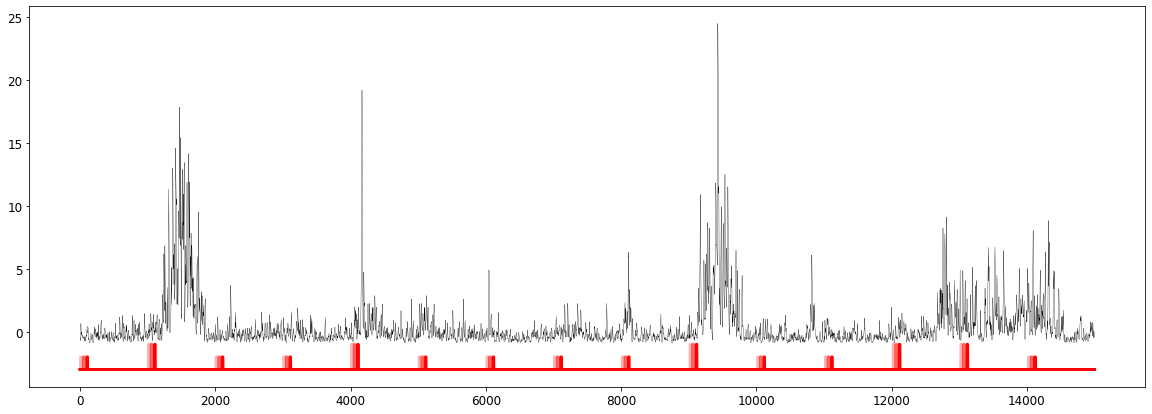

In [260]:
fig, ax = plt.subplots(figsize=(20, 7))
ax = plt.plot(data.loc[0:15000,'HFB'], 'k', linewidth=0.3)
ax = plt.plot(X_env[0:15000,10]-3, color = [1, 0, 0, 1], linewidth=3)
ax = plt.plot(X_env[0:15000,5]-3, color = [1, 0, 0, 0.6], linewidth=3)
ax = plt.plot(X_env[0:15000,1]-3, color = [1, 0, 0, 0.3], linewidth=3)

In [262]:
# Define the dependent variable
y = np.array(data.loc[:,'HFB']) # HFB

# Fit the model
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_env, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

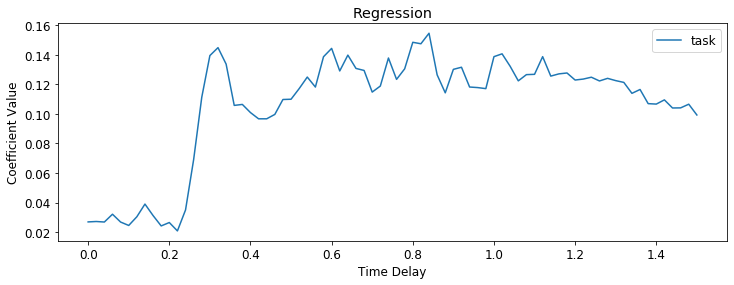

In [263]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'task')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [5]:
data_math = data.loc[data.loc[:,'task_general_cond_name'] == 2,:]

In [37]:
features = np.array(data_math.loc[:,'result'])
times = np.shape(np.unique(data_math.loc[:,'time']))
times = int(times[0])
r,c = np.shape(data_math)
trials = int(r/times)

# Reshape features
features_reshape = np.reshape(features, (trials, times))
features_reshape = np.expand_dims(features_reshape, axis=1)

# Add delayed features
fs = 500
time_window = 0.02;
#n_delays = 100
#delays = np.linspace(1, 2, 100)

start = 0; stop = 1.5; step = time_window
delays = np.arange(start, stop+step, step)
n_delays = int(len(delays))

X_delayed = np.zeros((trials,1,n_delays,times))
for i in range(trials):
    for ii in range(n_delays):
        window = [int(np.round(delays[ii]*fs)),int(np.round((delays[ii]+time_window)*fs))]
        X_delayed[i,0,ii,window[0]:window[1]] = int(np.unique(features_reshape[i]))
        
# Concatenate back the delayed features
X_env = X_delayed.reshape([X_delayed.shape[0], -1, X_delayed.shape[-1]])
X_env = np.hstack(X_env).T

In [38]:
np.shape(y)

(160160,)

In [39]:
# Define the dependent variable
y = np.array(data_math.loc[:,'HFB']) # HFB

# Fit the model
est = make_pipeline(StandardScaler(), LinearRegression())
est.fit(X_env, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

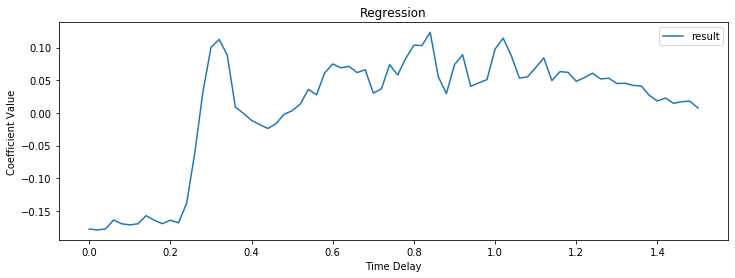

In [40]:
# Plot results
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(np.abs(delays), est.steps[-1][-1].coef_, label = 'result')

ax.set_xlabel('Time Delay')
ax.set_ylabel('Coefficient Value')
ax.set_title('Regression')
ax.legend()

In [36]:
np.unique(features_reshape)

array([1, 2])